In [7]:
import torch.nn.functional as F
import voc12.dataloader
import numpy as np
import argparse
import torch
import os
from PIL import Image
from torch.utils.data import DataLoader
from misc import pyutils, torchutils
from net.resnet50_cam import CAM, Net, PreCAM
from misc import imutils
import matplotlib.pyplot as plt
from torch import nn
from net import resnet50

In [12]:
baseline_cam_weight_path = '/Users/Andy/Projects/resnet50_baseline_512.pth'
trained_cam_weight_path = '/Users/Andy/Projects/resnet50_c2am_exp_01.pth'

model_baseline = CAM()
model_trained = CAM()
model_baseline.eval()
model_trained.eval()
model_baseline.load_state_dict(torch.load(baseline_cam_weight_path, map_location='cpu'))
model_trained.load_state_dict(torch.load(trained_cam_weight_path, map_location='cpu'))

<All keys matched successfully>

In [13]:
train_list = '/Users/Andy/Projects/c2am/voc12/train.txt'
voc12_root = '/Users/Andy/Projects/dataset/VOCdevkit/VOC2012'

train_dataset = voc12.dataloader.VOC12ClassificationDatasetMSF(train_list,
                                                          voc12_root=voc12_root,
                                                          scales=(1.0, 0.5, 1.5, 2.0))
train_loader = DataLoader(train_dataset, shuffle=False)

val_list = '/Users/Andy/Projects/c2am/voc12/val.txt'

val_dataset = voc12.dataloader.VOC12ClassificationDatasetMSF(val_list,
                                                          voc12_root=voc12_root,
                                                          scales=(1.0, 0.5, 1.5, 2.0))
val_loader = DataLoader(val_dataset, shuffle=False)

In [5]:
for pack in train_loader:
    name = pack['name'][0]
    # print(name)
    if name == '2008_004430':
        print(pack['label'][0])
        break

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0.])


In [14]:
with torch.no_grad():
    img_name = pack['name'][0]
    imgs = pack['img']
    label = pack['label'][0]
    size = pack['size']
    
    strided_up_size = imutils.get_strided_up_size(size, 16)
    
    baseline_outputs = [model_baseline(img[0]) for img in pack['img']]
    trained_outputs = [model_trained(img[0]) for img in pack['img']]
    
    baseline_highres_cam = [F.interpolate(torch.unsqueeze(
                o, 1), strided_up_size, mode='bilinear', align_corners=False) for o in baseline_outputs]
    baseline_highres_cam = torch.sum(torch.stack(baseline_highres_cam, 0), 0)[
                :, 0, :size[0], :size[1]]
    
    trained_highres_cam = [F.interpolate(torch.unsqueeze(
                o, 1), strided_up_size, mode='bilinear', align_corners=False) for o in trained_outputs]
    trained_highres_cam = torch.sum(torch.stack(trained_highres_cam, 0), 0)[
                :, 0, :size[0], :size[1]]

    valid_cat = torch.nonzero(label)[:, 0]

    baseline_highres_cam = baseline_highres_cam[valid_cat]
    trained_highres_cam = trained_highres_cam[valid_cat]
    baseline_highres_cam /= F.adaptive_max_pool2d(baseline_highres_cam, (1, 1)) + 1e-5
#     trained_highres_cam /= F.adaptive_max_pool2d(trained_highres_cam, (1, 1)) + 1e-5

In [17]:
trained_highres_cam_ = trained_highres_cam/0.2
trained_highres_cam_ /= F.adaptive_max_pool2d(trained_highres_cam_, (1, 1)) + 1e-5
print(trained_highres_cam.shape)
print(label)

torch.Size([1, 333, 500])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0.])


2008_004430


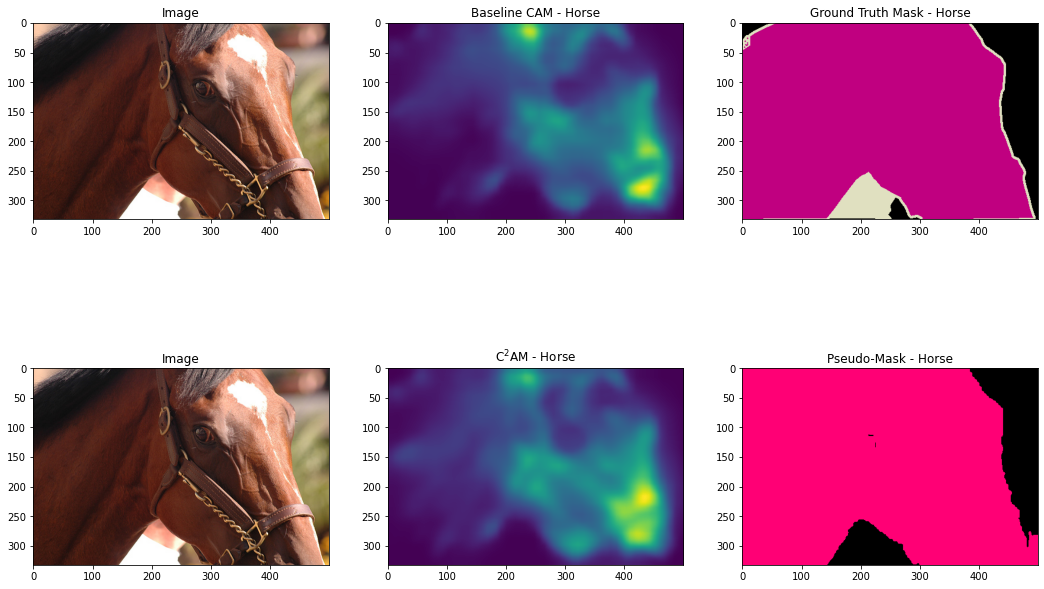

In [18]:
im = Image.open(os.path.join(voc12_root, 'JPEGImages', img_name + '.jpg'))
pseudo = Image.open(os.path.join(voc12_root, 'SegmentationClassAug', img_name + '.png'))
pseudo_color = imutils.colorize_label(np.asarray(pseudo))
gt = Image.open(os.path.join(voc12_root, 'SegmentationClass', img_name + '.png'))
print(img_name)
fig = plt.figure(figsize=(18,18))
ax1 = fig.add_subplot(331)
plt.title('Image')
ax1.imshow(im)
ax2 = fig.add_subplot(332)
plt.title('Baseline CAM - Horse')
ax2.imshow(baseline_highres_cam[0].squeeze())
ax2 = fig.add_subplot(333)
plt.title('Ground Truth Mask - Horse')
ax2.imshow(gt)
ax1 = fig.add_subplot(334)
plt.title('Image')
ax1.imshow(im)
ax2 = fig.add_subplot(335)
plt.title('C$^2$AM - Horse')
ax2.imshow(trained_highres_cam_[0].squeeze())
ax2 = fig.add_subplot(336)
plt.title('Pseudo-Mask - Horse')
ax2.imshow(pseudo_color)